In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5
from visualize import *
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")
# disentangled vae
sys.path.append('../disentangling-vae')
from collections import defaultdict
import vae_trim, vae_trim_viz
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import get_loss_f

### BTCVAE-1

In [2]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 1
args.attr_lamb = 0
args.epochs = 100
name = args.loss + "_B_" + str(args.btcvae_B) 
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

In [ ]:
# d_numer_norm = (jacob_norm**2).sum(axis=(1,2))
# d_denom_norm = (jacob_norm.sum(axis=2)**2).sum(axis=1)
# diversity_norm = d_numer_norm / d_denom_norm
# print(diversity_norm)

### BTCVAE-3

In [3]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 3
args.attr_lamb = 0
args.epochs = 100
name = args.loss + "_B_" + str(args.btcvae_B) 
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [29]:
inputs, labels = iter(train_loader).next()
inputs = inputs.to(device)
reconstruct, (mu, _), latent_sample = model(inputs)
mu1, _ = model.encoder(model.decoder(mu))

In [38]:
mu[0] - mu1[0]

tensor([-0.0205,  0.0102,  0.1553,  0.1051, -0.0485, -0.0690,  0.1608, -0.0537,
        -0.0519, -0.6313], device='cuda:0', grad_fn=<SubBackward0>)

In [33]:
mu1[0]

tensor([ 0.7764, -1.2664,  0.4404,  0.8765,  0.8272, -0.6060,  0.6523, -2.1265,
         0.5820, -0.7629], device='cuda:0', grad_fn=<SelectBackward>)

In [34]:
L2Loss(mu[0], mu1[0])

tensor(0.0473, device='cuda:0', grad_fn=<MeanBackward0>)

In [35]:
L2Loss(inputs[0], reconstruct[0])

tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)

In [37]:
inputs[0] - reconstruct[0]

tensor([[[-1.1397e-04, -2.8976e-06, -9.4455e-07,  ..., -5.7852e-08,
          -1.1602e-07, -3.4971e-06],
         [-3.2469e-06, -6.2790e-08, -4.1766e-08,  ..., -1.3718e-09,
          -2.1955e-09, -9.4979e-08],
         [-8.4504e-07, -2.5969e-08, -6.6165e-08,  ..., -1.5370e-09,
          -1.4356e-09, -3.8364e-08],
         ...,
         [-1.9642e-06, -6.8343e-07, -1.7307e-06,  ..., -6.6742e-08,
          -2.2769e-08, -1.1515e-07],
         [-4.7090e-06, -1.1423e-06, -4.3639e-07,  ..., -1.2553e-07,
          -9.2595e-08, -8.8304e-07],
         [-1.3147e-05, -2.0535e-07, -4.4770e-08,  ..., -7.5609e-08,
          -2.1745e-07, -8.9945e-06]]], device='cuda:0', grad_fn=<SubBackward0>)

In [26]:
mu, _ = model.encoder(model.decoder(latent_dist[0]))

In [27]:
mu.shape

torch.Size([64, 10])

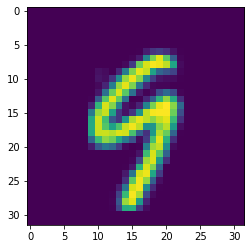

In [18]:
plt.imshow(inputs.detach().cpu().numpy()[0,0])

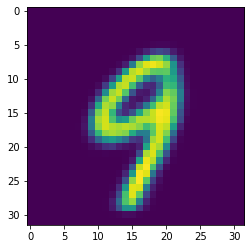

In [17]:
plt.imshow(reconstruct.detach().cpu().numpy()[0,0])

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

### BTCVAE-6

In [ ]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 6
args.attr_lamb = 0
args.epochs = 100
name = args.loss + "_B_" + str(args.btcvae_B) 
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

### BTCVAE-9

In [ ]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 9
args.attr_lamb = 0
args.epochs = 100
name = args.loss + "_B_" + str(args.btcvae_B) 
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

### BTCVAE-12

In [ ]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 12
args.attr_lamb = 0
args.epochs = 100
name = args.loss + "_B_" + str(args.btcvae_B) 
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

### BTCVAE-1-attr-20

In [ ]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 12
args.attr_lamb = 0
args.epochs = 100
name = "btcvae_B_1_attr_20_latent_sample_use_residuals"
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

### BTCVAE-1-attr-60

In [ ]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 12
args.attr_lamb = 0
args.epochs = 100
name = "btcvae_B_1_attr_60_latent_sample_use_residuals"
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

### BTCVAE-3-attr-60

In [ ]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 12
args.attr_lamb = 0
args.epochs = 100
name = "btcvae_B_3_attr_60_latent_sample_use_residuals"
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

### BTCVAE-3-attr-60-L1norm

In [ ]:
args = vae_trim.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 12
args.attr_lamb = 0
args.epochs = 100
name = "btcvae_B_3_attr_60_latent_sample_use_residuals_L1norm"
args.name = name

# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.batch_size, device)
metadata = load_metadata(exp_dir)

# load model
model = load_model(exp_dir, is_gpu=not args.no_cuda)
latent_map = DecoderEncoder(model, use_residuals=True)

L2Loss = torch.nn.MSELoss()

In [ ]:
Loss = 0
Diversity = 0
for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    recon_batch, latent_dist, latent_sample = model(inputs)

    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    s_output = latent_map(s, deepcopy(inputs))
    loss = 0
    for i in range(model.latent_dim):
        col_idx = np.arange(model.latent_dim)!=i
        gradients = torch.autograd.grad(s_output[:,i], s, grad_outputs=torch.ones_like(s_output[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]
        gradients_pairwise = gradients[:,col_idx]
        loss += L2Loss(gradients_pairwise, torch.zeros_like(gradients_pairwise))
    Loss += loss.item()
    
    s = deepcopy(latent_dist[0].detach())
    s = s.requires_grad_(True)
    x = model.decoder(s)

    grad = []
    for i in range(32*32):
        gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                        retain_graph=True, create_graph=True, only_inputs=True)[0]    
        grad.append(gradients)

    jacob = torch.stack(grad).permute(1, 0, 2)
    jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
    d_numer = (jacob**2).sum(axis=(1,2))
    d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
    diversity = d_numer / d_denom    
    Diversity += diversity.sum().item()
    
    print('\rIndex: {}/{}'.format(batch_idx+1, len(test_loader)), end='')

print('\n Loss: {}'.format(Loss))
print('\n Diversity: {}'.format(Diversity/10000))

In [ ]:
# if self.attr_lamb > 0:
#     s = deepcopy(latent_sample.detach())
#     s = s.requires_grad_(True)
#     x = self.model.decoder(s)
#     grad = []
#     for i in range(32*32):
#         gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
#                                         retain_graph=True, create_graph=True, only_inputs=True)[0]    
#         grad.append(gradients)

#     jacob = torch.stack(grad).permute(1, 0, 2)
#     d_numer = (jacob**2).sum(axis=(1,2))
#     d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
#     diversity = d_numer / d_denom   
#     loss += self.attr_lamb/batch_size * torch.norm(diversity - 1)**2

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)

Loss = 0
Diversity = 0
inputs, labels = iter(test_loader).next()
inputs = inputs.to(device)
labels = labels.to(device)
recon_batch, latent_dist, latent_sample = model(inputs)

s = deepcopy(latent_dist[0].detach())
s = s.requires_grad_(True)
x = model.decoder(s)

optimizer.zero_grad()

In [ ]:
grad = []
for i in range(32*32):
    gradients = torch.autograd.grad(x.view(-1,32*32)[:,i], s, grad_outputs=torch.ones_like(x.view(-1,32*32)[:,i]), 
                                    retain_graph=True, create_graph=True, only_inputs=True)[0]    
    grad.append(gradients)

jacob = torch.stack(grad).permute(1, 0, 2)
jacob_norm = jacob / torch.norm(jacob, dim=1).unsqueeze(1) 
d_numer = (jacob**2).sum(axis=(1,2))
d_denom = (jacob.sum(axis=2)**2).sum(axis=1)
diversity = d_numer / d_denom    
(torch.norm(diversity - 1)**2).backward()

In [ ]:
s = deepcopy(latent_sample.detach())
s = s.requires_grad_(True)
x = model.decoder(s)

eps = 1e-5
e = torch.eye(s.shape[1]).to(device)

grad = []
for i in range(s.shape[1]):
    x_shift = model.decoder(s + eps*e[i])
    grad.append((x_shift - x)/eps)
grad = torch.stack(grad).permute(1,2,3,4,0).view(64,32*32,10)

x_shift1 = model.decoder(s + eps*e[0])
x_shift2 = model.decoder(s + eps*e[1])       

grad1 = (x_shift1 - x)/eps
grad2 = (x_shift2 - x)/eps 

((grad1 * grad2).sum(axis=(1,2,3))**2).sum()

In [ ]:
s = deepcopy(latent_sample.detach())
s = s.requires_grad_(True)
x = model.decoder(s)
batch_size = s.shape[0]

eps = 1e-5
e = torch.eye(s.shape[1]).to(device)

grad = []
for i in range(s.shape[1]):
    x_shift = model.decoder(s + eps*e[i])
    grad.append((x_shift - x)/eps)
grad = torch.stack(grad).permute(1,2,3,4,0).view(batch_size,32*32,10)   

a = torch.matmul(grad.permute(0,2,1),grad)
ind = np.diag_indices(s.shape[1])
a[:, ind[0], ind[1]] = torch.zeros(s.shape[1]).to(device)                              
print((a**2).sum()/batch_size)

In [ ]:
s = deepcopy(latent_sample.detach())
s = s.requires_grad_(True)
batch_size = s.shape[0]

eps = 1e-5
e = torch.eye(s.shape[1]).to(device)

grad = []
for i in range(s.shape[1]):
    x_shift = model.decoder(s + 0.5*eps*e[i])
    x = model.decoder(s - 0.5*eps*e[i])
    grad.append((x_shift - x)/eps)
grad = torch.stack(grad).permute(1,2,3,4,0).view(batch_size,32*32,10)   

a = torch.matmul(grad.permute(0,2,1),grad)
ind = np.diag_indices(s.shape[1])
a[:, ind[0], ind[1]] = torch.zeros(s.shape[1]).to(device)                              
print((a**2).sum()/batch_size)

In [ ]:
a = torch.matmul(jacob.permute(0,2,1),jacob)
ind = np.diag_indices(s.shape[1])
a[:, ind[0], ind[1]] = torch.zeros(s.shape[1]).to(device)                              
print((a**2).sum()/batch_size)

In [ ]:
a = torch.matmul(jacob.permute(0,2,1),jacob)
ind = np.diag_indices(s.shape[1])
print(((a**2).sum() - (a[:,ind[0],ind[1]]**2).sum())/batch_size)

In [ ]:
a.shape

In [ ]:
torch.diag(tor)

In [ ]:
grad.shape

In [ ]:
(torch.matmul(grad.permute(0,2,1),grad)[:,0,1]**2).sum()

In [ ]:
a = torch.matmul(grad.permute(0,2,1),grad)
ind = np.diag_indices(s.shape[1])
a[:, ind[0], ind[1]] = torch.zeros(s.shape[1]).to(device)
(a**2).sum()

In [ ]:
(a**2).sum()

In [ ]:
s.grad

In [ ]:
s.shape

In [ ]:
s_ = model.encoder(model.decoder(s))